# Grad-CAM-MNIST

- Guided Backpropagation + Class Activation Map

## 1) Import required Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.autograd import Function

import matplotlib.pyplot as plt
%matplotlib inline  

import random
from skimage.transform import resize

## 2) Hyperparameters

In [2]:
batch_size = 128
learning_rate = 0.0001
num_epoch = 10

In [3]:
def one_sided_padding(x):
    rand1 = random.randrange(0,15,3)
    rand2 = random.randrange(0,15,3)

    zero = np.zeros(shape=[28,28,1])
    zero[rand1:rand1+12,rand2:rand2+12,:]=np.asarray(x).reshape(12,12,1)
    return zero

## 3) Dataloader

In [4]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

## 4) Classification Model

In [5]:
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature*8*7*7,1000),
            nn.ReLU(),
            nn.Linear(1000,10)
        )       
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            elif isinstance(m, nn.Linear):

                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(x.size()[0],-1)
        out = self.fc_layer(out)

        return out

model = nn.DataParallel(CNN().cuda())

## 5) Loss & Optimizer

In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 6) Train

In [7]:
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break
    

Test Data Accuracy: [94.40105]%
Test Data Accuracy: [94.43109]%
Test Data Accuracy: [96.524445]%
Test Data Accuracy: [96.27403]%
Test Data Accuracy: [97.586136]%
Test Data Accuracy: [97.42588]%
Test Data Accuracy: [94.68149]%
Test Data Accuracy: [97.11539]%
Test Data Accuracy: [97.92668]%
Test Data Accuracy: [98.10697]%


## 7) Guided Backpropagation ReLU

In [8]:
class GuidedBackpropRelu(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
     
guided_relu = GuidedBackpropRelu.apply

## 8) Guided Backprop ReLU Model

In [9]:
class GuidedReluModel(nn.Module):
    def __init__(self,model,to_be_replaced,replace_to):
        super(GuidedReluModel,self).__init__()
        self.model = model
        self.to_be_replaced = to_be_replaced
        self.replace_to = replace_to
        self.layers=[]
        self.output=[]
        
        for m in self.model.modules():
            if isinstance(m,self.to_be_replaced):
                self.layers.append(self.replace_to )
                #self.layers.append(m)
            elif isinstance(m,nn.Conv2d):
                self.layers.append(m)
            elif isinstance(m,nn.BatchNorm2d):
                self.layers.append(m)
            elif isinstance(m,nn.Linear):
                self.layers.append(m)
            elif isinstance(m,nn.AvgPool2d):
                self.layers.append(m)
                
        for i in self.layers:
            print(i)
        
        
    def reset_output(self):
        self.output = []
    
    def hook(self,grad):
        out = grad[:,0,:,:].cpu().data#.numpy()
        print("out_size:",out.size())
        self.output.append(out)
        
    def get_visual(self,idx,original_img):
        grad = self.output[0][idx]
        return grad
        
    def forward(self,x):
        out = x 
        out.register_hook(self.hook)
        for i in self.layers[:-3]:
            out = i(out)
        out = out.view(out.size()[0],-1)
        for j in self.layers[-3:]:
            out = j(out)
        return out
        
        

In [10]:
guide = GuidedReluModel(model,nn.ReLU,guided_relu)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
<built-in method apply of FunctionMeta object at 0x7fdc5e6b22c8>
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
<built-in method apply of FunctionMeta object at 0x7fdc5e6b22c8>
AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
<built-in method apply of FunctionMeta object at 0x7fdc5e6b22c8>
AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
<built-in method apply of FunctionMeta object at 0x7fdc5e6b22c8>
Linear(in_features=12544, out_features=1000, bias=True)
<built-in method apply of 

## 9) CAM

In [11]:
class CAM():
    def __init__(self,model):
        self.gradient = []
        self.model = model
        self.h = self.model.model.module.layer[-2].register_backward_hook(self.save_gradient)
        
    def save_gradient(self,*args):
        #print("Gradient saved!!!!")
        grad_input = args[1]
        grad_output= args[2]
        self.gradient.append(grad_output[0])
        #print(self.gradient[0].size())
        
    def get_gradient(self):
        return self.gradient[0]
    
    def remove_hook(self):
        self.h.remove()
            
    def normalize_cam(self,x):
        x = 2*(x-torch.min(x))/(torch.max(x)-torch.min(x)+1e-8)-1
        #x[x<torch.max(x)]=-1
        return x
    
    def visualize(self,cam_img,guided_img,img_var):
        guided_img = guided_img.numpy()
        cam_img = resize(cam_img.cpu().data.numpy(),output_shape=(28,28))
        x = img_var[0,:,:].cpu().data.numpy()

        fig = plt.figure(figsize=(20, 12)) 
        
        plt.subplot(1,4,1)
        plt.title("Original Image")
        plt.imshow(x,cmap="gray")

        plt.subplot(1,4,2)
        plt.title("Class Activation Map")
        plt.imshow(cam_img)

        plt.subplot(1,4,3)
        plt.title("Guided Backpropagation")
        plt.imshow(guided_img,cmap='gray')
        
        plt.subplot(1,4,4)
        plt.title("Guided x CAM")
        plt.imshow(guided_img*cam_img,cmap="gray")
        plt.show()
    
    def get_cam(self,idx):
        grad = self.get_gradient()
        alpha = torch.sum(grad,dim=3,keepdim=True)
        alpha = torch.sum(alpha,dim=2,keepdim=True)
        
        cam = alpha[idx]*grad[idx]
        cam = torch.sum(cam,dim=0)
        cam = self.normalize_cam(cam)
        self.remove_hook()
        
        return cam
   

In [12]:
cam = CAM(guide)

out_size: torch.Size([128, 28, 28])


/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


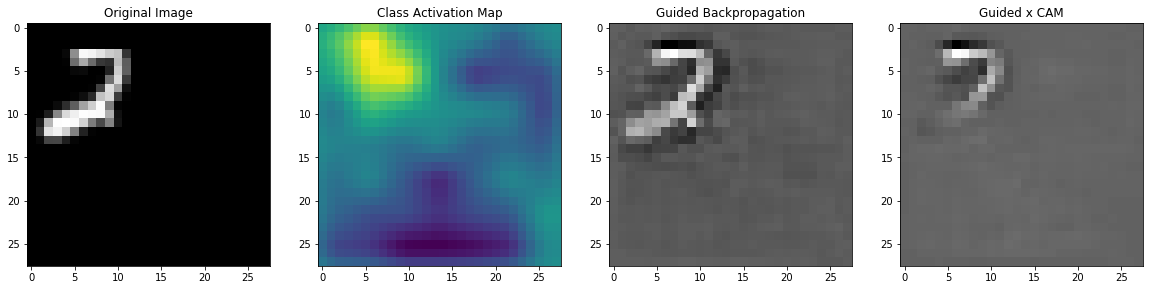

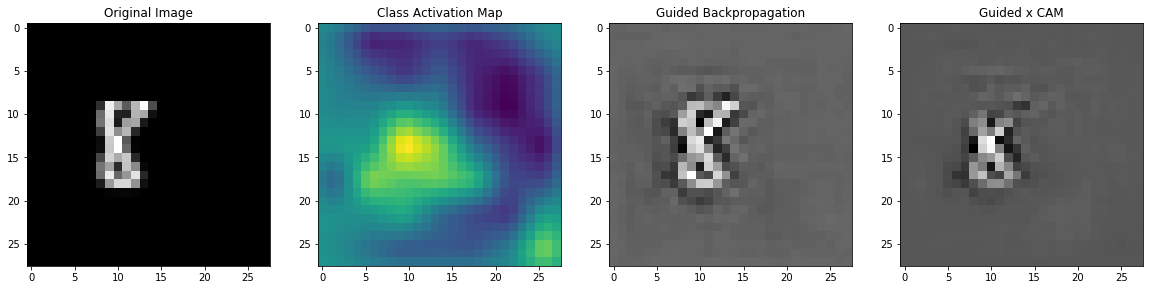

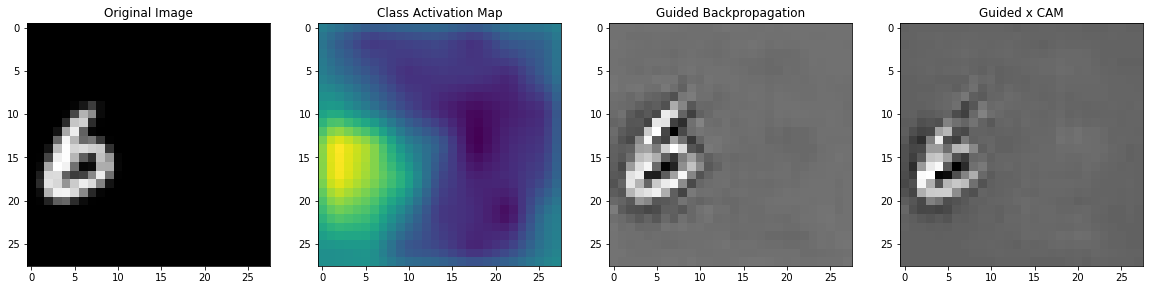

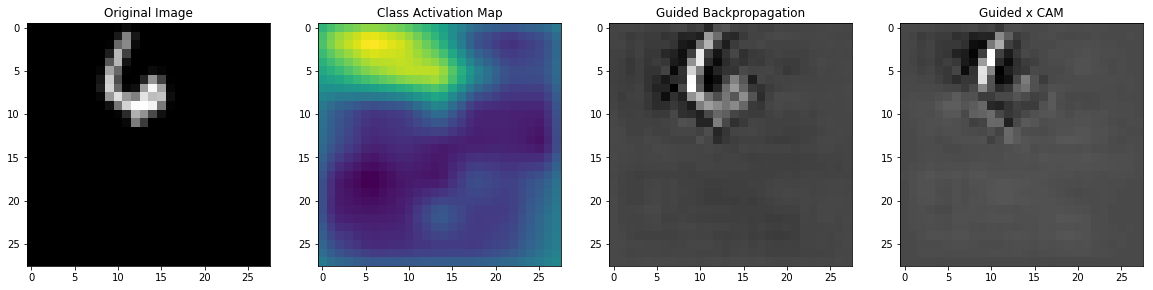

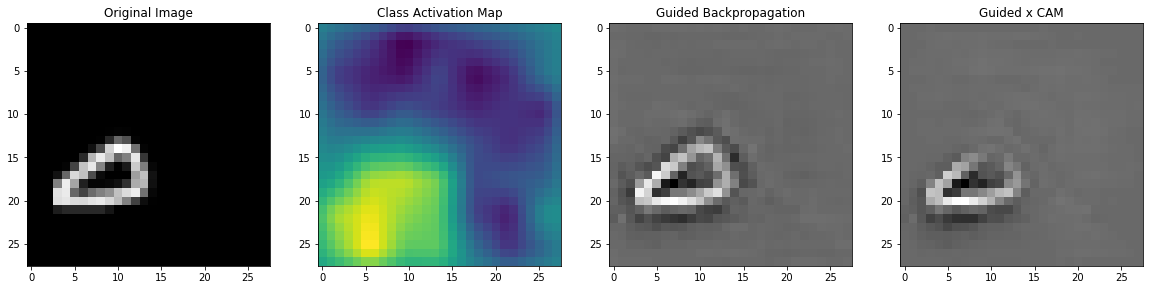

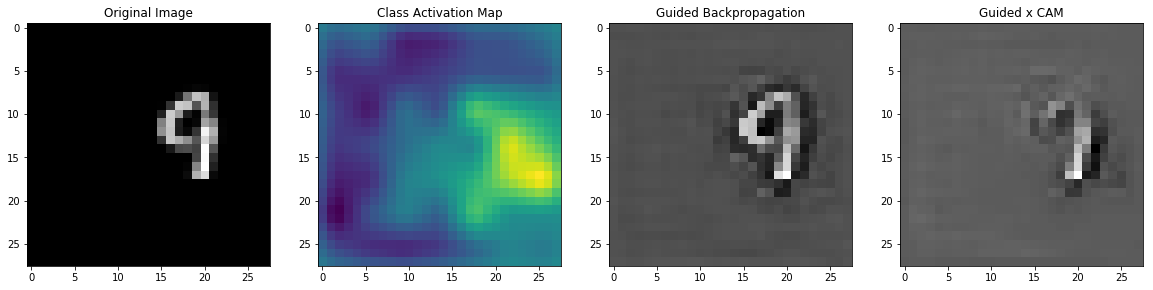

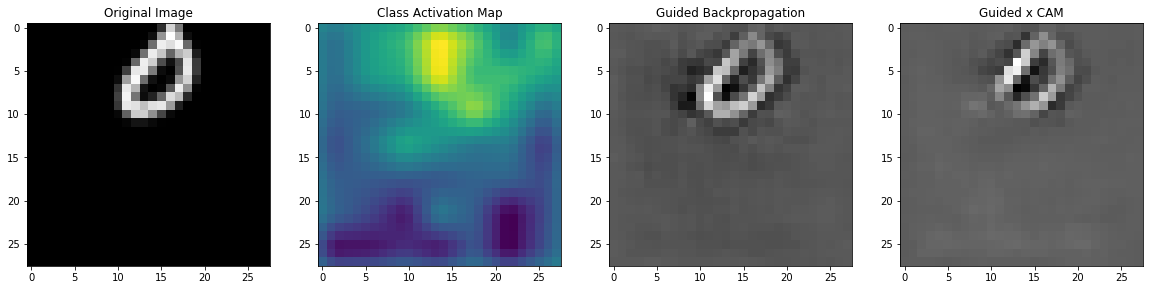

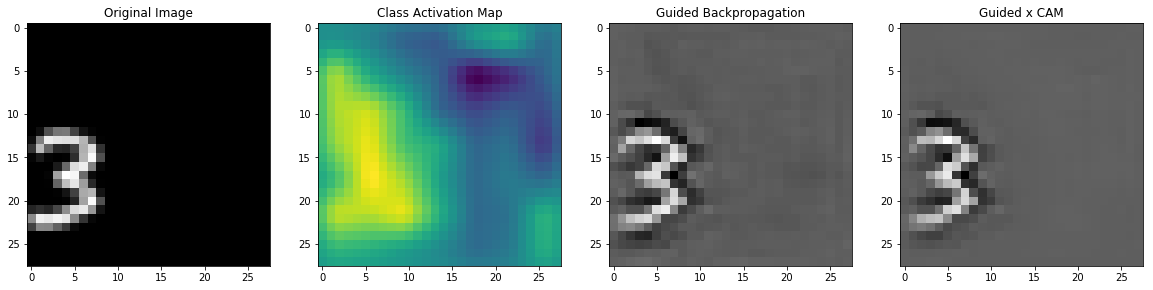

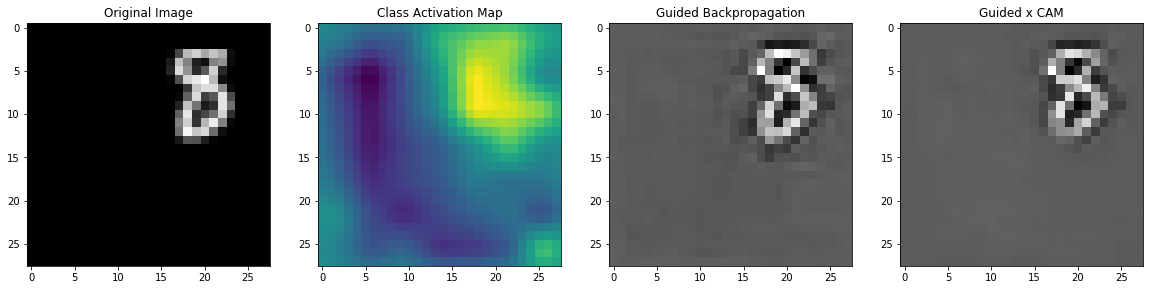

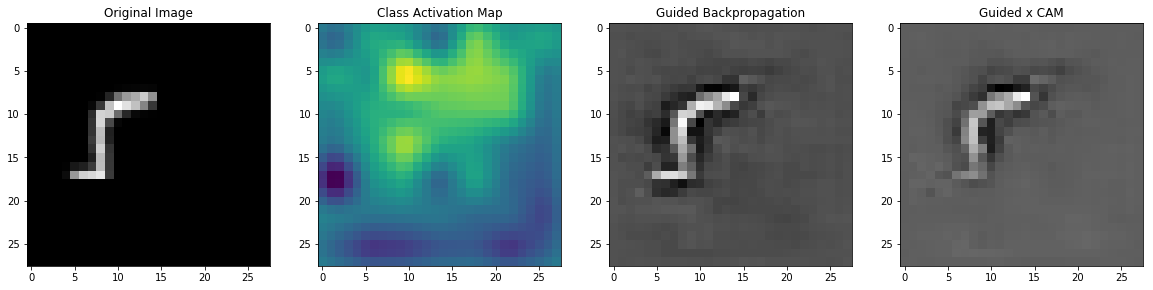

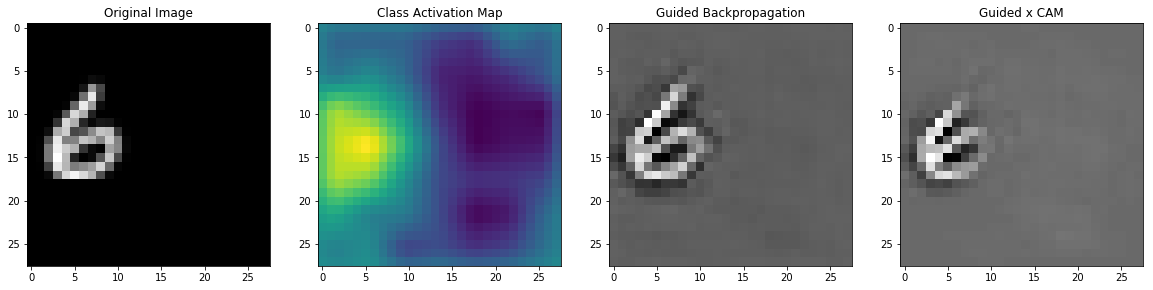

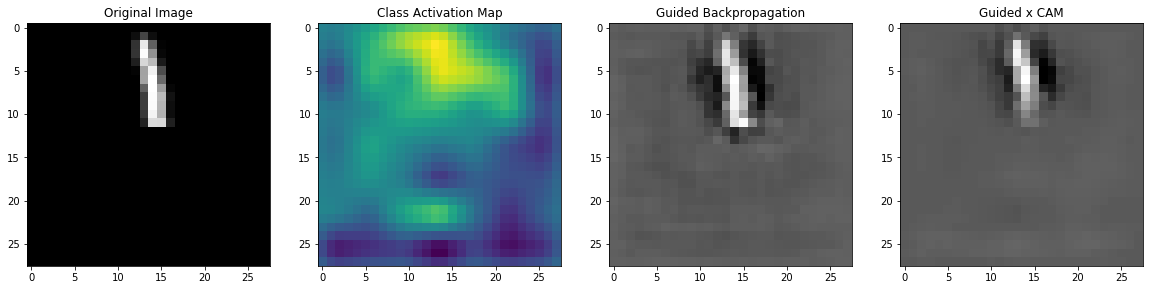

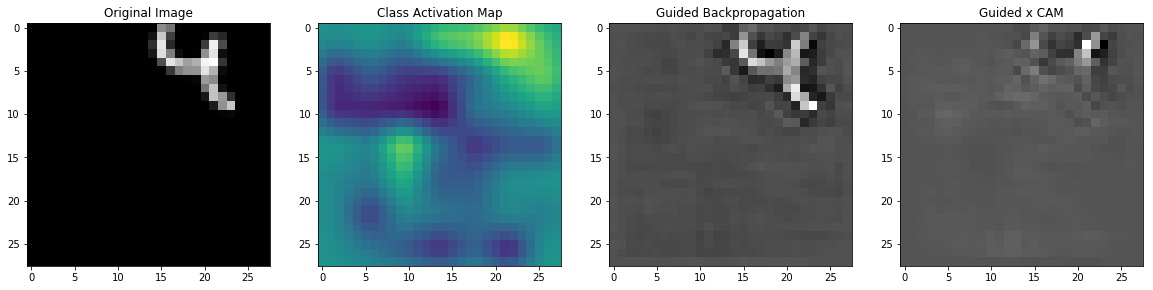

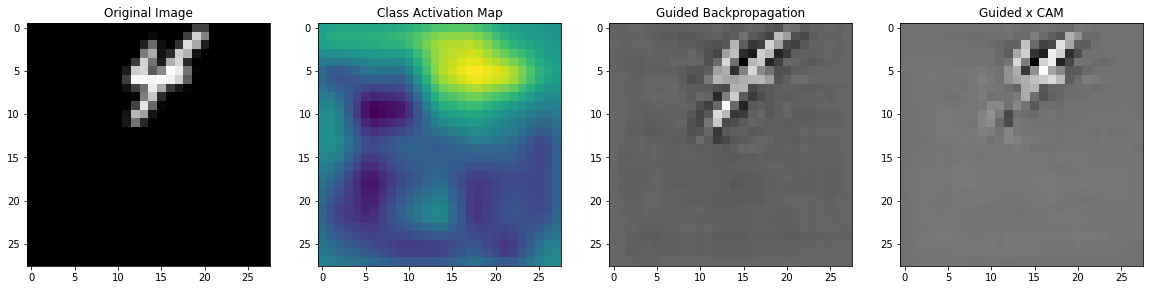

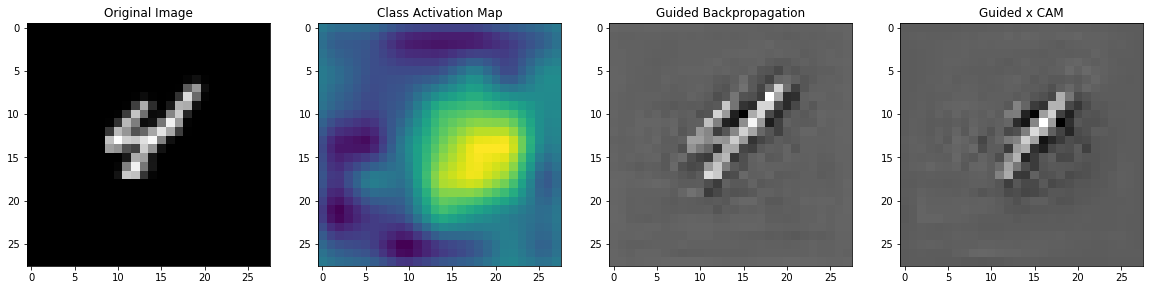

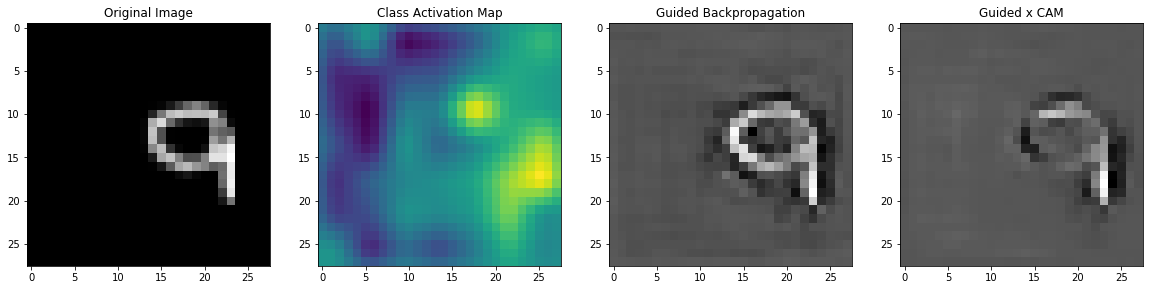

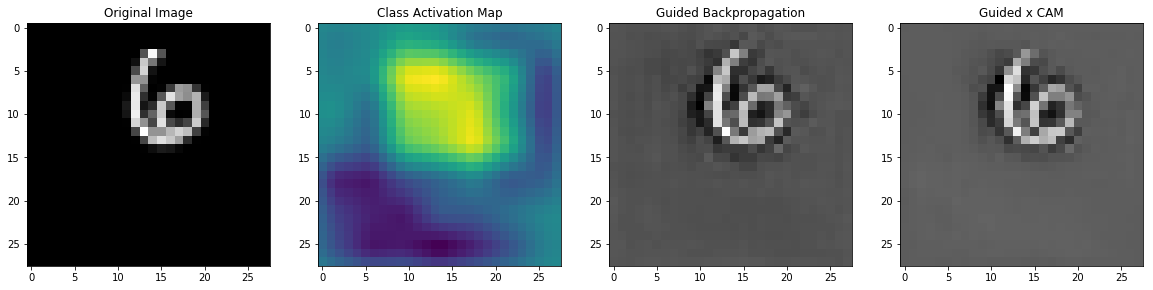

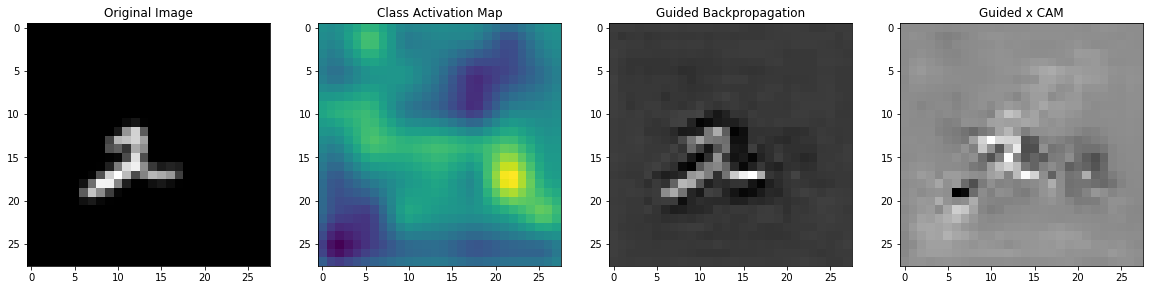

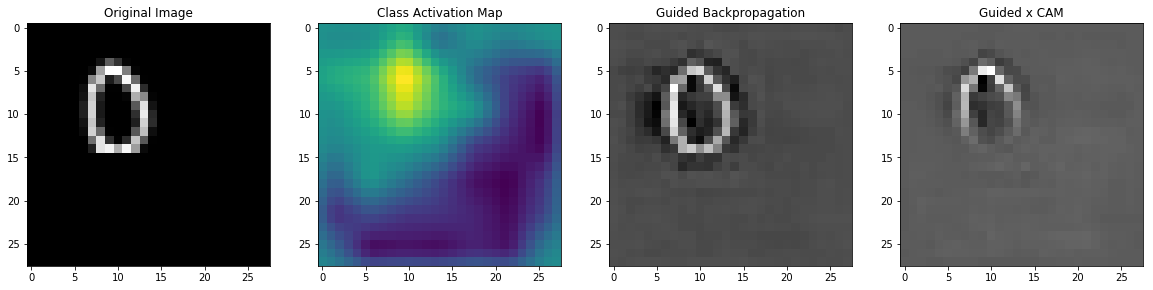

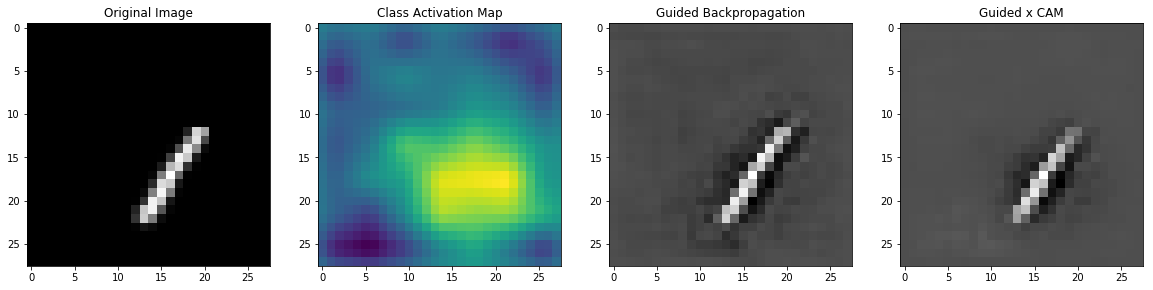

In [13]:
guide.reset_output()
for image,label in test_loader:
    x = Variable(image,requires_grad=True).cuda()
    y_= Variable(label).cuda()
        
    output = guide.forward(x) 
    output = torch.index_select(output,dim=1,index=y_)
    output = torch.sum(output)
    output.backward(retain_graph=True)
    
    for j in range(20):
        out = cam.get_cam(j)
        guided_img = guide.get_visual(j,x)
        cam.visualize(out,guided_img,x[j])
        
    break